In [2]:
import numpy as np
import random
import os
import pandas as pd
import cv2
import torch
import torchvision
from xml.etree import ElementTree as et
import shutil

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import argparse

!pip install pytorch_model_summary
!pip install adamp
!pip install torchsummary

from adamp import AdamP
import pytorch_model_summary
import torchsummary



In [3]:
!pip install --user albumentations

In [4]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [5]:
pwd

'C:\\Users\\cihat\\OneDrive\\Belgeler\\GitHub\\yoloV5-fruit-detection'

In [8]:
!mkdir data
!mkdir data\images
!mkdir data\labels
!mkdir data\images\train
!mkdir data\images\valid
!mkdir data\labels\train
!mkdir data\labels\valid

A subdirectory or file data already exists.


In [6]:
###### DATA ######
old_train_dir = 'train_zip/train'
old_test_dir = 'test_zip/test'
train_img_dir = 'data/images/train'
test_img_dir = 'data/images/valid'
train_label_dir = 'data/labels/train'
test_label_dir = 'data/labels/valid'
fruit_classes = ['apple', 'banana', 'orange']
img_w, img_h = 480, 480

###### MODEL ######
model_name = "Yolov5"
opt_name = "Adam"
lr = 0.001
epoch = 30

In [7]:
def get_files_count(folder_path):
    dirListing = os.listdir(folder_path)
    return len(dirListing)

len_train = get_files_count(old_train_dir)
len_test = get_files_count(old_test_dir)
print(f'train = {len_train}, test = {len_test}') # 480, 120

train_cnt, test_cnt = 0, 0
for train_file in os.listdir(old_train_dir):
    etc, ext = train_file.split('.')
    if ext == 'jpg':
        dir_from = os.path.join(old_train_dir, train_file)
        img_from = cv2.imread(dir_from, cv2.IMREAD_UNCHANGED)
        img_rgb = cv2.cvtColor(img_from, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (480, 480), cv2.INTER_AREA)
        dir_to = os.path.join(train_img_dir, train_file)
        cv2.imwrite(dir_to, img_from)
        
    if ext == 'xml':
        f = open(os.path.join(train_label_dir, etc + ".txt"), 'w')
        tree = et.parse(os.path.join(old_train_dir, train_file))
        root = tree.getroot()
        
        img_path = os.path.join(old_train_dir, etc + '.jpg')
        img = cv2.imread(img_path)
        width, height = img.shape[1], img.shape[0]
        
        for member in root.findall('object'):
            class_num = str(fruit_classes.index(member.find('name').text))
            xmin = int(member.find('bndbox').find('xmin').text) / width
            xmax = int(member.find('bndbox').find('xmax').text) / width
            ymin = int(member.find('bndbox').find('ymin').text) / height
            ymax = int(member.find('bndbox').find('ymax').text) / height
            
            x_center, y_center = str((xmin + xmax) / 2), str((ymin + ymax) / 2)
            w, h = str(xmax - xmin), str(ymax - ymin)
            f.write(class_num + " " + x_center + " " + y_center + " " + w + " " + h +'\n')
        
        f.close()
    train_cnt += 1
    
for test_file in os.listdir(old_test_dir):
    etc, ext = test_file.split('.')
    if ext == 'jpg':
        dir_from = os.path.join(old_test_dir, test_file)
        img_from = cv2.imread(dir_from, cv2.IMREAD_UNCHANGED)
        img_rgb = cv2.cvtColor(img_from, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (512, 512), cv2.INTER_AREA)
        dir_to = os.path.join(test_img_dir, test_file)
        cv2.imwrite(dir_to, img_from)
        
    if ext == 'xml':
        f = open(os.path.join(test_label_dir, etc + ".txt"), 'w')
        tree = et.parse(os.path.join(old_test_dir, test_file))
        root = tree.getroot()
        img_path = os.path.join(old_test_dir, etc + '.jpg')
        img = cv2.imread(img_path)
        width, height = img.shape[1], img.shape[0]
        for member in root.findall('object'):
            class_num = str(fruit_classes.index(member.find('name').text))
            xmin = int(member.find('bndbox').find('xmin').text) / width
            xmax = int(member.find('bndbox').find('xmax').text) / width
            ymin = int(member.find('bndbox').find('ymin').text) / height
            ymax = int(member.find('bndbox').find('ymax').text) / height
            
            x_center, y_center = str((xmin + xmax) / 2), str((ymin + ymax) / 2)
            w, h = str(xmax - xmin), str(ymax - ymin)
            f.write(class_num + " " + x_center + " " + y_center + " " + w + " " + h +'\n')
        
        f.close()
    test_cnt += 1

train = 480, test = 120


In [8]:
new_len_train_img = get_files_count('data/images/train')
new_len_train_label = get_files_count('data/labels/train')
new_len_valid_img = get_files_count('data/images/valid')
new_len_valid_label = get_files_count('data/labels/valid')

print(new_len_train_img, new_len_train_label, new_len_valid_img, new_len_valid_label)

240 240 60 60


In [9]:
class FruitDataset(torch.utils.data.Dataset):
    
    def __init__(self, file_dir, w, h, transforms = None):
        self.transforms = transforms
        self.w = w
        self.h = h
        self.file_dir = file_dir
        self.imgs = [image for image in sorted(os.listdir(file_dir)) if image[-4:] == '.jpg']
        self.classes = ['apple','banana','orange']
        
    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.file_dir, img_name)
        
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.w, self.h), cv2.INTER_AREA)
        img_res = img_res / 255.0 # normalization
        
        xml_name = img_name[:-4] + '.xml'
        xml_path = os.path.join(self.file_dir, xml_name)
        boxes = []
        labels = []
        tree = et.parse(xml_path)
        root = tree.getroot()
        
        img_w = img.shape[1]
        img_h = img.shape[0]
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            x_min = (int(member.find('bndbox').find('xmin').text) / img_w) * self.w
            x_max = (int(member.find('bndbox').find('xmax').text) / img_w) * self.w
            
            y_min = (int(member.find('bndbox').find('ymin').text) / img_h) * self.h
            y_max = (int(member.find('bndbox').find('ymax').text) / img_h) * self.h

            boxes.append([x_min, y_min, x_max, y_max])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = torch.tensor(labels)
        
        if self.transforms:
            sample = self.transforms(image = img_res, bboxes = target["boxes"], labels = labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
        
        img_res = torch.tensor(img_res)
        
        return img_res, idx, target
        
    def __len__(self):
        return len(self.imgs)
        
def get_transform(train):

    if train:
        return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([A.Rotate(limit=10),
                 A.RandomBrightness(),
                 A.Cutout(num_holes=8, max_h_size=1, max_w_size=1, fill_value=1),
                 ], p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def plot_bbox(img, target):
    fig, bbox = plt.subplots(1,1)
    bbox.imshow(img.permute(1, 2, 0))
    
    for box in target["boxes"]:
        x, y, w, h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y), w, h, linewidth = 2, edgecolor = 'r', facecolor = 'none')
        bbox.add_patch(rect)
        
    plt.show()

C:\Users\cihat\AppData\Roaming\Python\Python39\site-packages\albumentations\augmentations\transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\cihat\AppData\Roaming\Python\Python39\site-packages\albumentations\augmentations\dropout\cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
C:\Users\cihat\AppData\Local\Temp\ipykernel_14568\1083734131.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_res = torch.tensor(img_res)


dataset_length: train = 240, val = 240


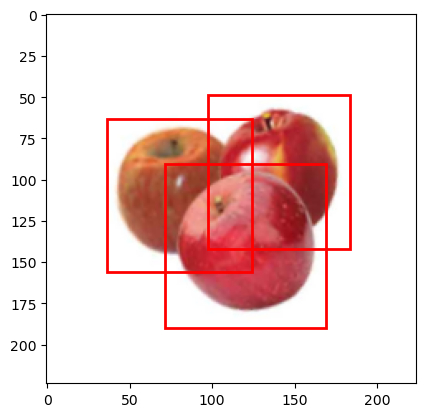

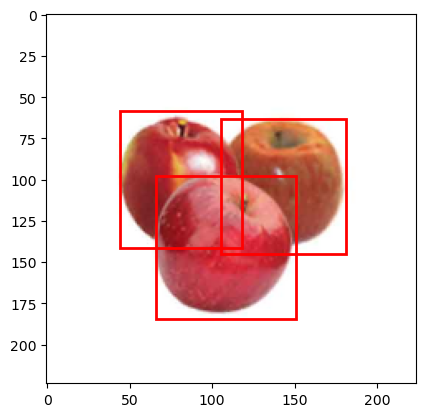

In [10]:
data_train = FruitDataset(old_train_dir, 224, 224, transforms = get_transform(train=True))
data_val = FruitDataset(old_train_dir, 224, 224, transforms = get_transform(train=False))

img_train, idx_train, target_train = data_train[15]
img_val, idx_val, target_val = data_val[15]

print(f'dataset_length: train = {len(data_train)}, val = {len(data_val)}')

plot_bbox(img_train, target_train)
plot_bbox(img_val, target_val)

In [21]:
import yaml

data_yaml = dict(
    train = 'data/images/train',
    val = 'data/images/train',
    nc = 3,
    names = ['apple','banana','orange']
)

with open('data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

In [23]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...


In [ ]:
!cd yolov5 && python train.py --img 512 --batch 16 --epochs 20 --data data.yaml --weights yolov5s.pt --workers 2

In [ ]:
!cd yolov5 && python train.py --img 512 --batch 16 --epochs 50 --data data.yaml --weights yolov5s.pt --workers 2

In [ ]:
!cd yolov5 && python train.py --img 512 --batch 16 --epochs 100 --data data.yaml --weights yolov5s.pt --workers 2

In [33]:
!python ./yolov5/train.py --img 512 --batch 16 --epochs 150 --data data.yaml --weights yolov5m6/yolov5m6.pt --workers 2

train: weights=yolov5m6/yolov5m6.pt, cfg=, data=data.yaml, hyp=yolov5\data\hyps\hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=yolov5\runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-48-g5f8054c Python-3.9.13 torch-1.8.1+cu111 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degre

In [36]:
%pwd

'C:\\Users\\cihat\\OneDrive\\Belgeler\\GitHub\\yoloV5-fruit-detection'

In [38]:
!python ./yolov5/detect.py --weights ./yolov5/runs/train/exp7/weights/best.pt --source data/images/valid --save-txt --save-conf

detect: weights=['./yolov5/runs/train/exp7/weights/best.pt'], source=data/images/valid, data=yolov5\data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5\runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-48-g5f8054c Python-3.9.13 torch-1.8.1+cu111 CPU

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/60 C:\Users\cihat\OneDrive\Belgeler\GitHub\yoloV5-fruit-detection\data\images\valid\apple_77.jpg: 512x640 5 apples, 260.2ms
image 2/60 C:\Users\cihat\OneDrive\Belgeler\GitHub\yoloV5-fruit-detection\data\images\valid\apple_78.jpg: 640x640 1 apple, 316.3ms
image 3/60 C:\Users\cihat\OneDrive\Belgeler\GitHub\yoloV5-fruit-detection\data\images\vali

In [41]:
%pwd

'C:\\Users\\cihat\\OneDrive\\Belgeler\\GitHub\\yoloV5-fruit-detection'

In [44]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp7/weights/best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to C:\Users\cihat/.cache\torch\hub\master.zip
YOLOv5  2022-12-25 Python-3.9.13 torch-1.8.1+cu111 CPU

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [52]:
img = os.path.join('muz3.jpg')

In [53]:
results = model(img)

In [54]:
results

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 221x387 6 bananas
Speed: 10.0ms pre-process, 202.2ms inference, 1.0ms NMS per image at shape (1, 3, 384, 640)

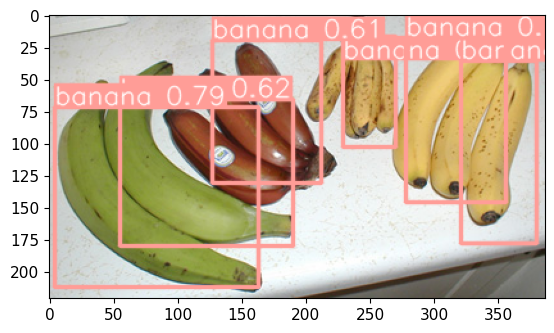

In [55]:
%matplotlib inline 
plt.imshow(np.squeeze(results.render()))
plt.show()